# Derive the empirical variogram of our DEM differences

Empirical variogram provides insight into the accurarcy and quality of elevation data by assessing the spatial autocorrelation of residual errors in the products. This is from the [xdem package](https://github.com/GlacioHack/xdem/tree/main), more specifically a function in the [spatial stats code](https://github.com/GlacioHack/xdem/blob/main/xdem/spatialstats.py#L1137). See plots in [Knuth et al 2023](https://www.sciencedirect.com/science/article/pii/S0034425722004850#sec5) [Figure 9](https://ars.els-cdn.com/content/image/1-s2.0-S0034425722004850-gr9_lrg.jpg) and [Figure S9](https://ars.els-cdn.com/content/image/1-s2.0-S0034425722004850-mmc1.pdf/#page=14),  Hugonnet et al 2022 [Figure 5](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9815885), as well as a [notebook provided by Shashank](https://github.com/dshean/hma_mb_paper/blob/master/notebooks/nogzumpa_dh_dt_error_correlation.ipynb). 

The **range** and the **sill** are primary parameters in a variogram. For our purpose, *we want a low range* because it indicates a 'noisier', more random, or less-correlated DEM difference product ('blob' sizes are smaller). The sill represents the amplitude of the 'blobs' or the magnitude of the differences in the oscillation between our positive and negative pixels. The sill depends greatly on the surface we're trying to represent, but *a low sill* would indicate a smoother product; this is obviously preferred. Also, we choose a **model** to represent our empirical variogram, which is especially important at finer spatial scales. We use *a spherical model* following literature because it more accurately captures the observed noise at short spatial scales in the data than other models, such as a Gaussian model, without being too extreme (e.g. exponential model). A few notes:

- We only want to assess this over stable terrain
- The empirical variogram helps quantify the spatial dependence structure of elevation values. It reveals how elevation values are correlated or related to each other across different distances. In the context of DEMs, it can indicate the presence of systematic errors, such as striping or block artifacts, or spatial trends that might need to be addressed
- A positive tail on the variogram with spatial lag indicate spatially correlated error

Import our DEMs

In [3]:
# reference DEM
temp_ifsar = '/path/to/ifsar_DEM.tif' # IFSAR DEM used as coregistration reference

In [4]:
# obtain initial DEM difference files (difference between DEM and reference DEM (2012 IFSAR)
orig_1938_diff = rOpen('/path/to/1938_DEM_diff.tif')
orig_1957_diff = rOpen('/path/to/1957_DEM_diff.tif')
orig_1978_diff = rOpen('/path/to/1978_DEM_diff.tif')
orig_2004_diff = rOpen('/path/to/2004_DEM_diff.tif')
orig_2023_diff = rOpen('/path/to/2023_DEM_diff.tif')


In [5]:
# obtain coregistered DEM difference files
demcoreg_1938 = rOpen('/path/to/1938_DEM_coregistered_diff_filt.tif')
demcoreg_1957 = rOpen('/path/to/1957_DEM_coregistered_diff_filt.tif')
demcoreg_1978 = rOpen('/path/to/1978_DEM_coregistered_diff_filt.tif')
demcoreg_2004 = rOpen('/path/to/2004_DEM_coregistered_diff_filt.tif')
demcoreg_2023 = rOpen('/path/to/2023_DEM_coregistered_diff_filt.tif')


In [6]:
# raster resolution
res_1938 = rOpen(demcoreg_1938, returnArray=False, returnRes=True)[0]
res_1957 = rOpen(demcoreg_1957, returnArray=False, returnRes=True)[0]
res_1978 = rOpen(demcoreg_1978, returnArray=False, returnRes=True)[0]
res_2004 = rOpen(demcoreg_2004, returnArray=False, returnRes=True)[0]
res_2023 = rOpen(demcoreg_2023, returnArray=False, returnRes=True)[0]


In [7]:
# remove off-glacier values
orig_1938_diff[demcoreg_1938 == 0] = np.nan
orig_1957_diff[demcoreg_1957 == 0] = np.nan
orig_1978_diff[demcoreg_1978 == 0] = np.nan
orig_2004_diff[demcoreg_2004 == -32768] = np.nan
orig_2023_diff[demcoreg_2023 == 0] = np.nan

demcoreg_1938[demcoreg_1938 == 0] = np.nan
demcoreg_1957[demcoreg_1957 == 0] = np.nan
demcoreg_1978[demcoreg_1978 == 0] = np.nan
demcoreg_2004[demcoreg_2004 == -32768] = np.nan
demcoreg_2023[demcoreg_2023 == 0] = np.nan


### Sample Empirical Variogram

We use the *sample_empirical_variogram* function from [xdem](https://github.com/GlacioHack/xdem/blob/main/xdem/spatialstats.py)

If we want to use skg.Variogram, we can follow [something like this](https://gatorglaciology.github.io/gstatsimbook/2_Variogram_model.html)

When fitting a spherical model to an empirical variogram, the spherical model includes three parameters: the nugget (psill), the range, and the sill. The nugget effect represents the small-scale variability or measurement error that cannot be explained by spatial dependence. The range parameter defines the distance beyond which the correlation between data points diminishes, and the sill represents the maximum level of spatial dependence or variance. FACT CHECK THIS^^


From Hugonnet et al 2022:
- Partial sills: correlated variance (express as percentage of total sill? normalize variance axis?) -- the variance where the empirical variogram appears to level off. Variogram points above the sill indicate negative spatial correlation, while points below the sill indicate positive correlation. The variogram may not exhibit a sill if trends are present in the data.
- Range: correlation length -- the distance after which the variogram levels off. The physical meaning of the range is that pairs of points that are this distance or greater apart are not spatially correlated.


- ***...we sample 5 unique variograms...***: `n_variograms` = 5
- ***...with sample size 10,000***: `subsample` = 10,000
- ***...we use a weighted least squares..*** : `fit_sigma` = 'sq'
- ***...to fit a double-range...***: `max_lag` = 500 
- ***...nested spherical variogram model...***: `list_models` = 'Spherical'

*Note: if we run 10,000 samples and 5 variogram estimations, it will take ~20min*

In [18]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'

In [31]:
def plot_variograms(data1, data2, res, n_sample=10000, n_var=5, sr_dist=500, vmin=-25, vmax=25,
                    label1=None, label2=None, title=None, save_title=None):
    '''
    Code to plot an empirical variogram
    # data1: np array of data to compute variogram (e.g. differenced DEM before coregistration)
    # data2: np array of data to compute variogram (e.g. differenced DEM after coregistration)
    # res: array spacing (i.e. raster resolution)
    # n_sample: number of samples to randomly draw from the values
    # n_var: number of independent empirical variogram estimations (to estimate empirical variogram spread)
    # sr_dist: short-range distance--maximum variogram distance for short-range model
    # vmin, vmax: min and max values for DEM difference colorbar
    # label1, label2: labels for data1, data2
    # title: plot title
    # save_title: figure title if we want to save it
    '''
    # Create figure and axes (we create two rows so we can properly format the colorbar)
    n = len(data1)
    width_r = [19, 1]*n
    width_r.append(1)
    fig, axs = plt.subplots(nrows=5, ncols=2*n+1, sharex=False, sharey=True, figsize=(8*n, 40), 
                            gridspec_kw={'height_ratios': [6.8, 6.8, 5, 2, 4], 'width_ratios': width_r, 
                                         'hspace': 0.01, 'wspace': 0})

    for i in range(n):
        gs1 = axs[0,2*i].get_gridspec()
        # remove the underlying axes
        axs[4,2*i].remove()
        axs[4,2*i+1].remove()
        axs[3,2*i].remove()
        axs[3,2*i+1].remove()
        axs[2,2*i].remove()
        axs[2,2*i+1].remove()
        axs[1,2*i+1].remove()
        axs[0,2*i+1].remove()

        axs[0,2*i].axis('off')
        axs[1,2*i].axis('off')
    
        # redefine our axes by combining gridspaces
        ax1 = fig.add_subplot(gs1[4, 2*i:2*i+2])
        ax2 = fig.add_subplot(gs1[3, 2*i:2*i+2])
        ax3 = fig.add_subplot(gs1[2, 2*i:2*i+2])
        ax4 = fig.add_subplot(gs1[1, 2*i:2*i+2])
        ax5 = fig.add_subplot(gs1[0, 2*i:2*i+2])
        if i == n-1:
            ax6 = fig.add_subplot(gs1[:2, 2*i+2])
            p6 = ax6.get_position()
            ax6.set_position([p6.x0 + (p6.width/3), p6.y0, p6.width, p6.height])
            for j in range(5):
                axs[j,2*i+2].axis('off')

        # adjust axis sizing/spacing
        f = 0.85
        p1 = ax1.get_position()
        ax1.set_position([p1.x0 + ((p1.width - p1.width*f)/2), p1.y0, p1.width * f, p1.height * f])
        p2 = ax2.get_position()
        ax2.set_position([p1.x0 + ((p2.width - p2.width*f)/2), p2.y0, p2.width * f, p2.height * f])
        p3 = ax3.get_position()
        ax3.set_position([p3.x0 + ((p3.width - p3.width*f)/2), p3.y0 + ((p3.height - p3.height*f)/1.4), p3.width * f, p3.height * f])
                    
        # compute basic statistics on datasets (median and NMAD)
        med1 = round(np.nanmedian(data1[i]), 2)
        nmad1 = round(1.4826*np.nanmedian(abs(data1[i] - med1)), 2)
        med2 = round(np.nanmedian(data2[i]), 2)
        nmad2 = round(1.4826*np.nanmedian(abs(data2[i] - med2)), 2)
    
        # Compute the empirical variogram
        variogram1 = sample_empirical_variogram(data1[i], gsd=res[i], subsample=n_sample, n_variograms=n_var, fit_sigma='sq')
        variogram_short1 = sample_empirical_variogram(data1[i], gsd=res[i], subsample=n_sample, n_variograms=n_var, 
                                                      fit_sigma='sq', maxlag=sr_dist)
        variogram2 = sample_empirical_variogram(data2[i], gsd=res[i], subsample=n_sample, n_variograms=n_var, fit_sigma='sq')
        variogram_short2 = sample_empirical_variogram(data2[i], gsd=res[i], subsample=n_sample, n_variograms=n_var, 
                                                      fit_sigma='sq', maxlag=sr_dist)
        
        # Extract distances and semivariances from the variograms
        distances1 = variogram1.lags
        variances1 = variogram1.exp
        counts1 = variogram1['count']
        distances2 = variogram2.lags
        variances2 = variogram2.exp
        counts2 = variogram2['count']
        
        # topmost figure, ax5: original DEM difference
        c5 = ax5.imshow(data1[i], cmap='RdBu', vmin=vmin, vmax=vmax)
        if i == 0:
            ax5.add_artist(ScaleBar(dx=res[i], units='m', location='lower right', 
                                    length_fraction=0.3, width_fraction=0.02, border_pad=0.3, frameon=False)) # add scalebar
        ax5.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # second to top figure, ax4: aligned DEM difference
        c4 = ax4.imshow(data2[i], cmap='RdBu', vmin=vmin, vmax=vmax)
        # ax4.add_artist(ScaleBar(dx=res[i], units='m')) # add scalebar
        ax4.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # ax6: add colorbar to top two axes
        if i == n-1:
            col_ax = inset_axes(ax6, width="90%", height="90%", loc='center', borderpad=0)
            fig.colorbar(c5, cax=col_ax, label='Elevation difference (m)', extend='both')
            ax6.axis('off')
        # set border colors
        ax5.spines['left'].set_color('mediumseagreen')
        ax5.spines['left'].set_linewidth(6)
        ax5.spines['right'].set_color('mediumseagreen')
        ax5.spines['right'].set_linewidth(6)
        ax5.spines['top'].set_color('mediumseagreen')
        ax5.spines['top'].set_linewidth(6)
        ax5.spines['bottom'].set_color('mediumseagreen')
        ax5.spines['bottom'].set_linewidth(6)
        ax4.spines['left'].set_color('cornflowerblue')
        ax4.spines['left'].set_linewidth(6)
        ax4.spines['right'].set_color('cornflowerblue')
        ax4.spines['right'].set_linewidth(6)
        ax4.spines['top'].set_color('cornflowerblue')
        ax4.spines['top'].set_linewidth(6)
        ax4.spines['bottom'].set_color('cornflowerblue')
        ax4.spines['bottom'].set_linewidth(6)
    
        
        # histogram of elevation difference
        ax3.hist(data1[i].flatten(), bins=np.linspace(vmin,vmax,161), color='mediumseagreen', alpha=0.5)
        ax3.hist(data2[i].flatten(), bins=np.linspace(vmin,vmax,161), color='cornflowerblue', alpha=0.5)
        ax3.axvline(x=0, color='white', linestyle='dashed')
        stats_text1 = 'med: ' + str(med1) + '\nnmad: ' + str(nmad1)
        stats_text2 = 'med: ' + str(med2) + '\nnmad: ' + str(nmad2)
        ax3.text(0.01, 0.97, stats_text1, c='mediumseagreen', ha='left', va='top', alpha=0.8, size=26, 
                 transform=ax3.transAxes)
        ax3.text(0.99, 0.97, stats_text2, c='cornflowerblue', ha='right', va='top', alpha=0.8, size=26, 
                 transform=ax3.transAxes)

    
        # Plot empirical variograms
        ax1.plot(distances1, variances1, 'gx', label=None)
        ax1.plot(distances2, variances2, 'bx', label=None)
    
        # spherical variogram model on empirical variogram
        spherical_fit1, fit_params1 = fit_sum_model_variogram(list_models=['Spherical'], empirical_variogram=variogram1)
        spherical_fit2, fit_params2 = fit_sum_model_variogram(list_models=['Spherical'], empirical_variogram=variogram2)
        spherical_fit_short1, fit_params1 = fit_sum_model_variogram(list_models=['Spherical'], 
                                                                    empirical_variogram=variogram_short1)
        spherical_fit_short2, fit_params2 = fit_sum_model_variogram(list_models=['Spherical'], 
                                                                    empirical_variogram=variogram_short2)
        param_text1 = ('Range: ' + str(round(fit_params1['range'][0], 2)) + 
                       '    pSill: ' + str(round(fit_params1['psill'][0], 2)))
        param_text2 = ('Range: ' + str(round(fit_params2['range'][0], 2)) + 
                       '    pSill: ' + str(round(fit_params2['psill'][0], 2)))
        
        xmax = ax1.get_xlim()[1]
        linspace_x = np.linspace(0, xmax, 100)
        ax1.plot(linspace_x, spherical_fit1(linspace_x), color='mediumseagreen', ls='dashed', label='long-range model')
        ax1.plot(linspace_x, spherical_fit2(linspace_x), color='cornflowerblue', ls='dashed')
        ax1.plot(linspace_x, spherical_fit_short1(linspace_x), color='mediumseagreen', ls='dashdot', 
                 label='short-range model')
        ax1.plot(linspace_x, spherical_fit_short2(linspace_x), color='cornflowerblue', ls='dashdot')
    #     ax1.text(0.99, 0.99, '-- long-range model\n-·- short-range model', transform=ax1.transAxes, color='k', 
    #              ha='right', va='top', rotation='horizontal')
        # ax1.text(0.99, 0.1, param_text1, transform=ax1.transAxes, color='mediumseagreen', 
        #          ha='right', va='bottom', rotation='horizontal', size=22) # write range & sill 1
        # ax1.text(0.99, 0.1, param_text2, transform=ax1.transAxes, color='cornflowerblue', 
        #          ha='right', va='top', rotation='horizontal', size=22) # write range & sill 2

    
        # Plot pixel count bar graph
        midpoints1 = (distances1.values[:-1] + distances1.values[1:]) / 2
        midpoints1 = np.insert(midpoints1, 0, 0)
        bar_widths1 = np.diff(midpoints1)
        bar_widths1 = np.append(bar_widths1, xmax - midpoints1[-1]) * 0.4
        
        midpoints2 = (distances2.values[:-1] + distances2.values[1:]) / 2
        midpoints2 = np.insert(midpoints2, 0, 0)
        bar_widths2 = np.diff(midpoints2)
        bar_widths2 = np.append(bar_widths2, xmax - midpoints2[-1]) * 0.4
        
        ax2.bar(distances1, counts1, color='mediumseagreen', align='edge', width=bar_widths1, alpha=1, label=label1,
                edgecolor='lightgray', linewidth=0.5, zorder=0)
        ax2.bar(distances2, counts2, color='cornflowerblue', align='edge', width=-bar_widths2, alpha=1, label=label2,
                edgecolor='lightgray', linewidth=0.5, zorder=1)
        
        # Set plot titles and labels
    #     ax1.set_title('Empirical Variogram')
    #     ax2.set_title('Count of Pixels')
        ax1.set_xlabel('Distance (m)')
        # ax1.set_xscale('log')
        ax1.set_xlim([10, 3500])
        ax1.set_ylim(0)
        # ax2.set_xscale('log')
        ax2.set_xlim([10, 3500])
        ax2.set_ylim([0, 200000])
        ax2.xaxis.set_tick_params(labelbottom=False)
        ax3.set_xlabel('Elevation difference (m)')
        ax3.set_xlim([vmin, vmax])
        ax3.xaxis.tick_bottom()
        ax3.xaxis.set_label_position('bottom') 
        # ax2.legend(loc='lower right', prop={'size': 14})
        
        # label plots on the right to make things more clear
        ax5.text(0.5, 1.07, title[i], transform=ax5.transAxes, color='k', 
                 ha='center', va='top', rotation='horizontal', size=36, weight='bold')

        if i != 0:
            ax2.yaxis.set_tick_params(labelleft=False)
        if i == 0:
            ax1.set_ylabel('Variance (m)')
            ax2.set_ylabel('Count (px)')
            ax3.set_ylabel('Count (px)')
            ax5.text(-0.07, 0.5, 'Original', transform=ax5.transAxes, color='mediumseagreen', 
                     ha='center', va='center', rotation='vertical', size=36, weight='bold')
            ax4.text(-0.07, 0.5, 'Coregistered', transform=ax4.transAxes, color='cornflowerblue', ha='center', va='center', 
                     rotation='vertical', size=36, weight='bold')
        if i == n-1:
            ax1_leg = ax1.legend(loc='lower right', facecolor='w', edgecolor='w', framealpha=1, prop={'size': 26})
            for l in ax1_leg.get_lines(): # make the line color black
                l.set_color('k')
            # ax3.text(1.1, 0.5, 'Elevation difference\ndistribution', transform=ax3.transAxes, ha='center', va='center', 
            #          rotation='vertical', size=28, weight='bold')
            # ax1.text(1.1, 0.5, 'Spatially correlated\nerror', transform=ax1.transAxes, ha='center', va='center', 
            #          rotation='vertical', size=28, weight='bold')

        ax1.tick_params(which='both', left=True, right=False, bottom=True, top=True, direction='inout', length=12, width=2)
        ax2.tick_params(which='both', left=True, right=False, bottom=True, top=False, direction='inout', length=12, width=2)
        ax3.tick_params(which='both', left=True, right=False, bottom=True, top=False, direction='inout', length=12, width=2)

    # plt.subplots_adjust(hspace=0.1)    
    # plt.suptitle('DEM Co-registration Results', size=24, weight='bold')
    plt.show()
    if save_title is not None:
        fig.savefig(save_title, dpi=300, pad_inches=0)
        

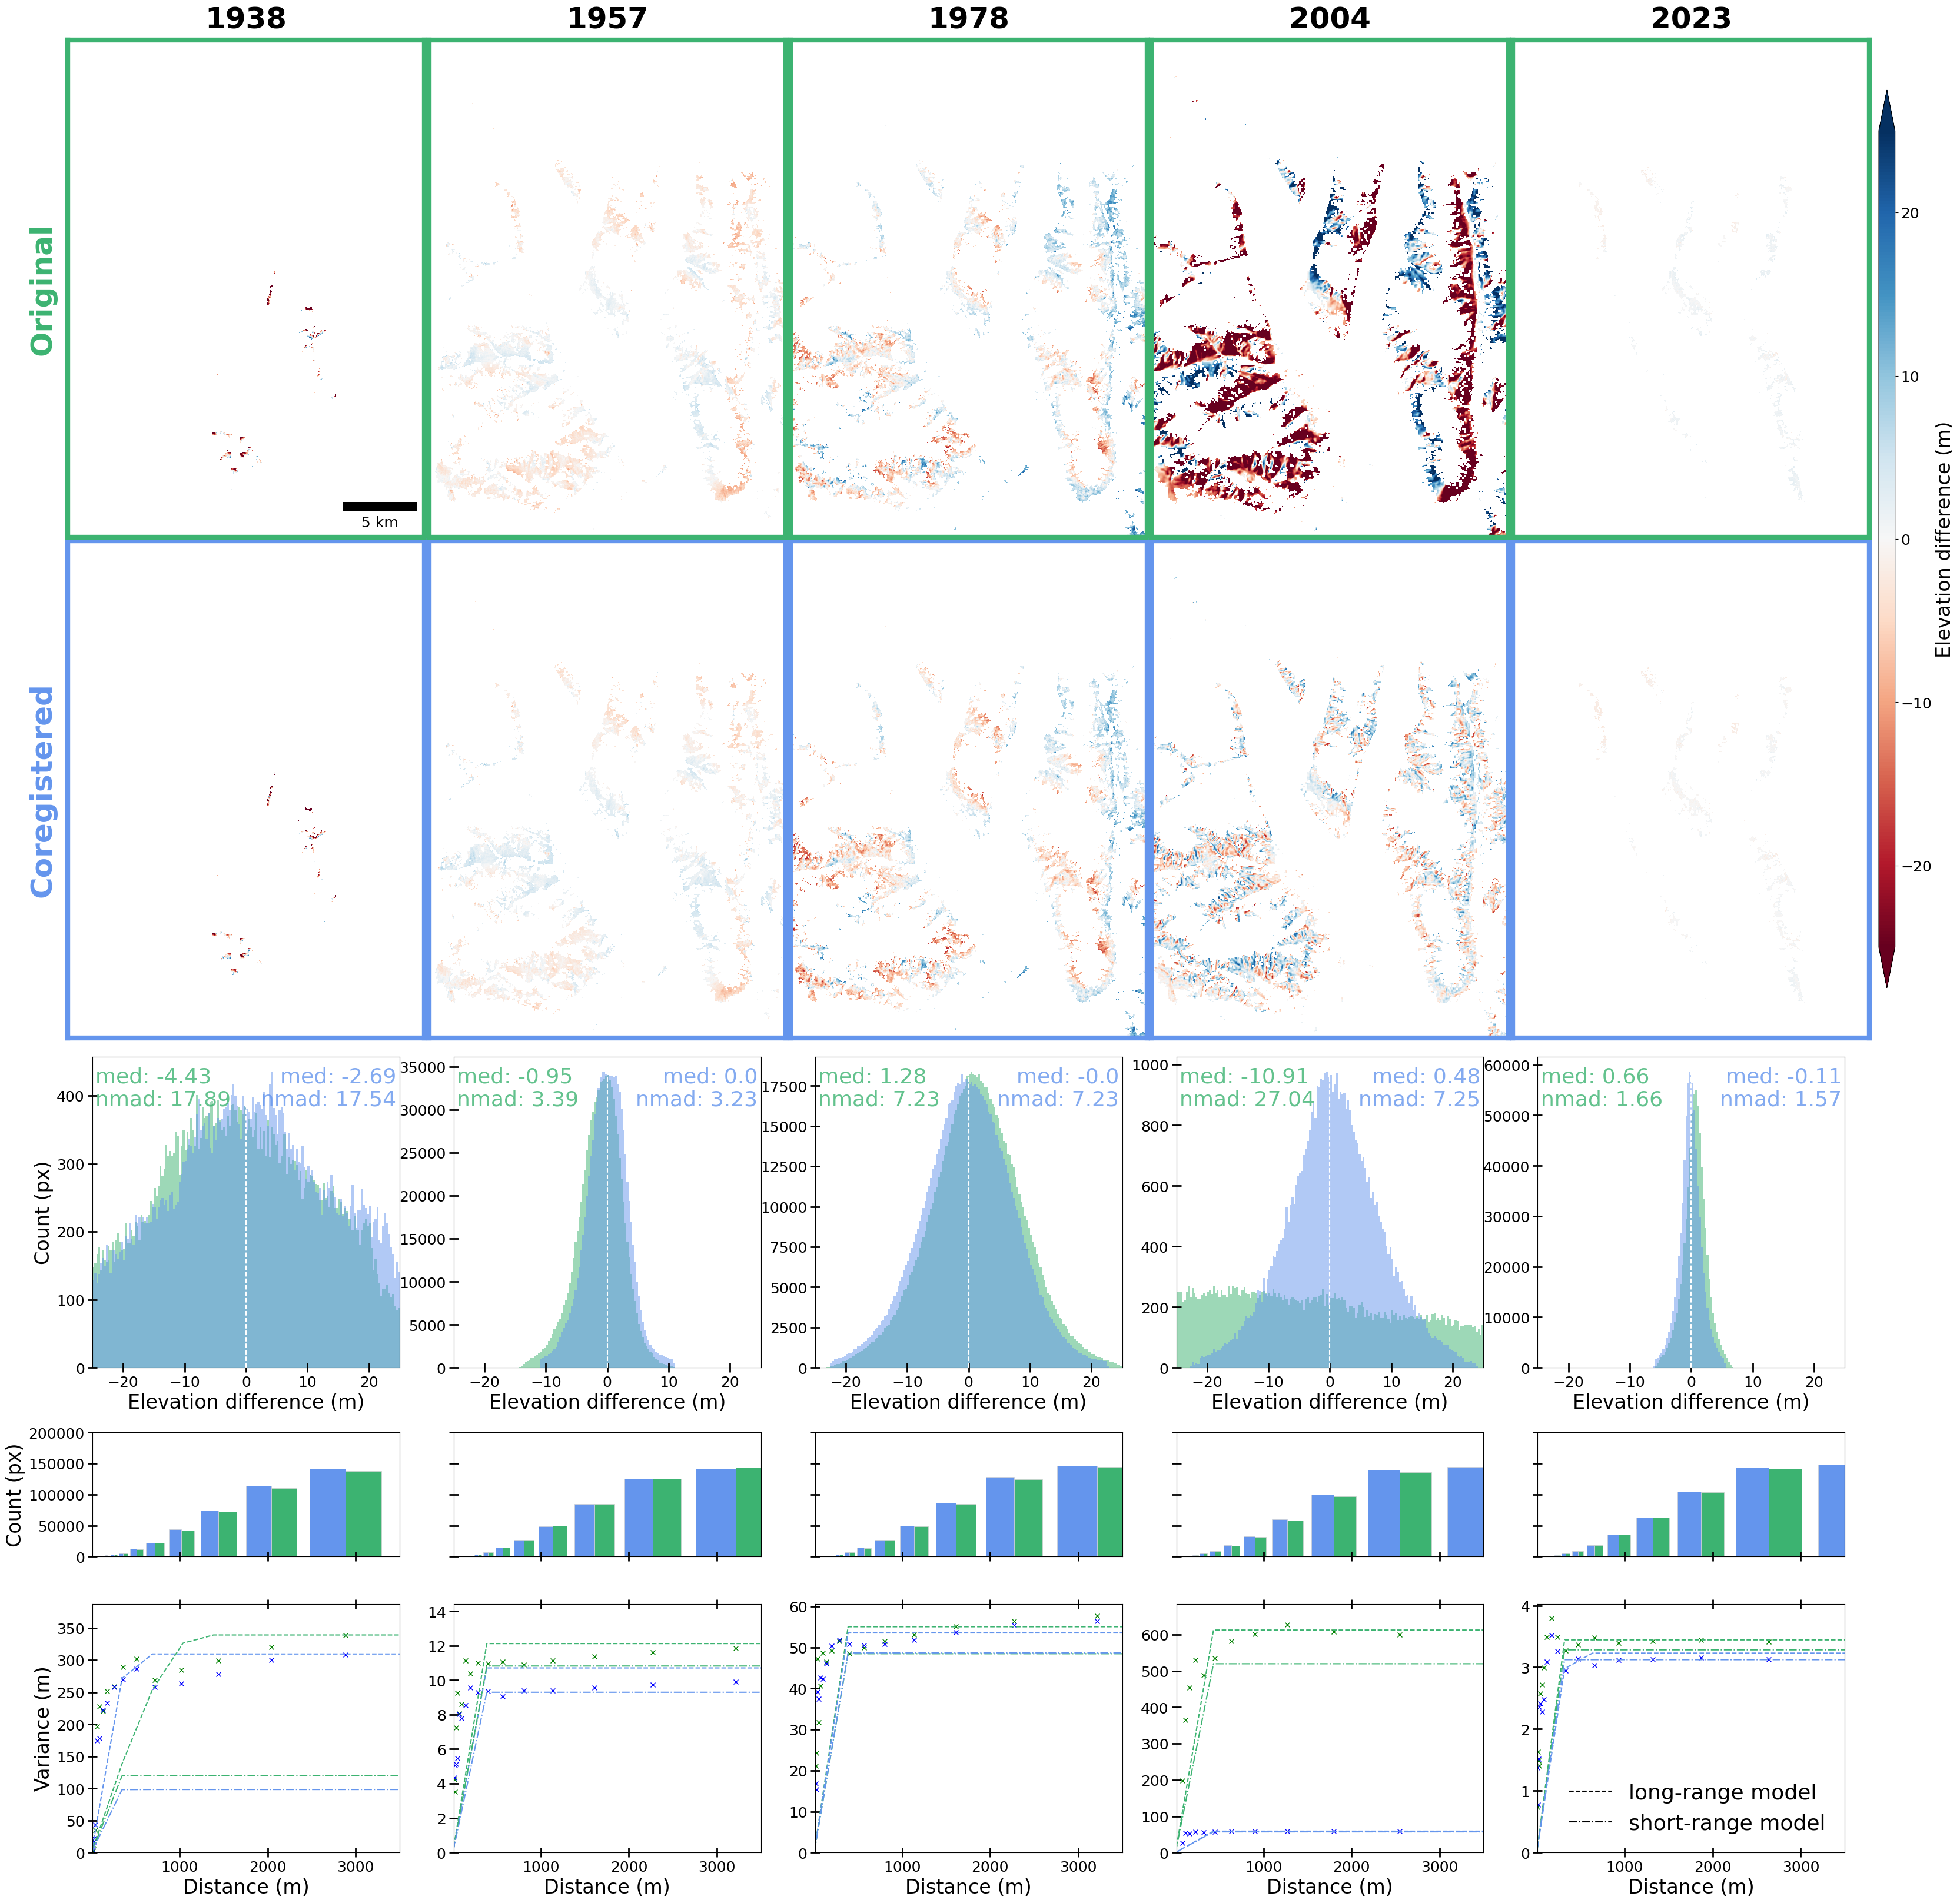

In [32]:
plot_variograms([orig_1938_diff, orig_1957_diff, orig_1978_diff, orig_2004_diff, orig_2023_diff], 
                [demcoreg_1938, demcoreg_1957, demcoreg_1978, demcoreg_2004, demcoreg_2023], 
                res=[res_1938, res_1957, res_1978, res_2004, res_2023], 
                n_sample=1000, n_var=5, sr_dist=500, vmin=-25, vmax=25, 
                label1='Original DEM', label2='Coregistered DEM', 
                title=['1938', '1957', '1978', '2004', '2023'], save_title=None)
